# Setup
## Import Libraries

In [1]:
%pylab inline
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits import mplot3d
from sklearn.metrics import mean_squared_error
from statannot import add_stat_annotation

import warnings
import itertools


Populating the interactive namespace from numpy and matplotlib


# K2: singles and pair effect experiment

## Setup


### Create lists of sample types for later use  

In [2]:
isolates=['BI', 'CB', 'CF', 'EA', 'EC1', 'EC10', 'EC11', 'EC12','EC14', 
          'EC16','EC17', 'EC18', 'EC9', 'Ecoli', 'Gh11','Gh12','Gh16',
          'Gh22', 'Gh24','Gh28', 'Gh29', 'Gh30', 'Gh35', 'Gh36','Gh38',
          'Gh40', 'Gh43', 'Gh44', 'Gh50', 'Gh54', 'Gh59', 'Gh60','Gh61',
          'Gh62', 'Gh67', 'Gh68', 'Gh9','KA', 'LA', 'OGI19-L','OGI33-L',
          'Og122', 'Og84', 'Og85', 'Og87', 'Og90','Og92', 'PAg1','PAg3', 
          'PAl', 'PH', 'PK', 'PP', 'ParPR2', 'RP1', 'RP1_A','RP1_B', 
          'RP2', 'SF1', 'SF2', 'Ut12', 'Ut14', 'Ut22']
monos=  ['Mono1','Mono2','Mono']
blanks= ['Blank1','Blank2']

timepoints=['t0','t1','t2','t3']


### Load and orginze data

In [3]:
warnings.filterwarnings("ignore")

#Pair chips with their data files
data_files=dict(zip(range(1,13),["EC_A","EC_B","EA_A","EA_B","RP1_A","RP1_B","BI_A","BI_B",
                                 "CF_A","CF_B","PAg_A","PAg_B"]))

#Load data from all chips into dictionary
chips_dict={}
for chip in range(1,13):
    chips_dict[data_files[chip]]=pd.read_csv('Data/kChip_data/k2/chip'+str(chip)+'.csv')
    
    area_mode=chips_dict[data_files[chip]]['t0_Area'].mode()[0]
    margin=area_mode*0.3
    chips_dict[data_files[chip]]=chips_dict[data_files[chip]][(chips_dict[data_files[chip]].t0_Area>(area_mode-margin)) &
                           (chips_dict[data_files[chip]].t0_Area<(area_mode+margin)) & (chips_dict[data_files[chip]].Total==2)]
    chips_dict[data_files[chip]]['chip']=chr(ord('@')+(chip%2+1))
    
#Merge replicate chips
chips_dict2={}
for focal in ["EC","EA","RP1","BI","CF","PAg"]:
    chips_dict2[focal]=chips_dict[focal+'_A'].append(chips_dict[focal+'_B'])

chips_dict=chips_dict2

"""Subtract t0 value for each well individually (so we are measuring added biomass)"""

n_chips_dict={}
for chip in chips_dict:
    df=chips_dict[chip].copy()

    #normalize each well to its own starting value
    df.t1=df.t1-df.t0
    df.t2=df.t2-df.t0
    df.t3=df.t3-df.t0
    df.t0=df.t0-df.t0
    
    #ensure no negative values or zero to avoid inf values later on
    df[timepoints]=df[timepoints].clip(lower=1)
    
    n_chips_dict[chip]=df

In [4]:
usable_isos=(pd.read_csv('usable_isos_per_target.csv')
            .drop(columns='Unnamed: 0')
             .rename(columns={'EColi_gfp':'EC', 'EA_gfp':'EA', 'RP1_gfp':'RP1',
                                        'PAg1_gfp':'PAg', 'BI_gfp':'BI', 'CF_gfp':'CF'}))

usable_isos_dict={}
for chip in n_chips_dict:
    usable_isos_dict[chip]=usable_isos[chip].to_list()
    
f_chips_dict={}
    
for chip in n_chips_dict:
    temp_df=n_chips_dict[chip].reset_index()
    for i in temp_df.index:
        if (temp_df.at[i,'sample1'] in usable_isos_dict[chip] and
            temp_df.at[i,'sample2'] in usable_isos_dict[chip]):
            temp_df.at[i,'good_to_use']='y'
        else:
            temp_df.at[i,'good_to_use']='n'

    temp_df=temp_df[temp_df.good_to_use=='y']
    f_chips_dict[chip]=temp_df    

### Load growth curve data

In [5]:
#dictionary to match samples to identifiers
phylo=pd.read_excel('Data/Strains.xlsx')
phylo_dict=dict(zip(phylo['Sample Name'],phylo['Identifier']))
r_phylo_dict=dict(zip(phylo['Identifier'],phylo['Sample Name']))

gc_data=pd.read_csv('Data/Isolate_profiling/gc_data.csv')
gc_data['old_sample_name']=gc_data['sample'].map(r_phylo_dict)
max_od_dict=dict(zip(gc_data['old_sample_name'],gc_data.max_od))

In [6]:
usable_isos=((pd.read_csv('usable_isos_per_target.csv')
             .drop(columns='Unnamed: 0')
             .rename(columns={'EColi_gfp':'EC', 'EA_gfp':'EA', 'RP1_gfp':'RP1',
                                        'PAg1_gfp':'PAg', 'BI_gfp':'BI', 'CF_gfp':'CF'})))

usable_isos_dict={}
for chip in n_chips_dict:
    usable_isos_dict[chip]=usable_isos[chip].to_list()
    
f_chips_dict={}
    
for chip in n_chips_dict:
    temp_df=n_chips_dict[chip].reset_index()
    for i in temp_df.index:
        if (temp_df.at[i,'sample1'] in usable_isos_dict[chip] and
            temp_df.at[i,'sample2'] in usable_isos_dict[chip]):
            temp_df.at[i,'good_to_use']='y'
        
        elif (temp_df.at[i,'sample1'] in monos and 
              temp_df.at[i,'sample2'] in monos):
                temp_df.at[i,'good_to_use']='y'
                
        elif (temp_df.at[i,'sample1'] in monos and 
              temp_df.at[i,'sample2'] in usable_isos_dict[chip]) :
                temp_df.at[i,'good_to_use']='y'
                
        elif (temp_df.at[i,'sample2'] in monos and 
              temp_df.at[i,'sample1'] in usable_isos_dict[chip]) :
                temp_df.at[i,'good_to_use']='y'
        else:
            temp_df.at[i,'good_to_use']='n'

    temp_df=temp_df[temp_df.good_to_use=='y']
    f_chips_dict[chip]=(temp_df.replace(phylo_dict)
                        .replace({'EColi':'Ecoli'}))
#                         .drop_duplicates(subset='sample',)
#                         .set_index('sample'))

In [7]:
def modified_S (row):
    if row["mono_s1_effect"]>0 and row["mono_s2_effect"]>0:
        row['modified_strongest']=row[["mono_s1_effect","mono_s2_effect"]].max()
    else: row['modified_strongest']=row[["mono_s1_effect","mono_s2_effect"]].min()
    return row

def comm_size(row):
    
    #assign community size
    if row['sample1']==row['sample2']: 
        row['comm_size']='single'
    elif row['sample1']=='Mono': 
        row['comm_size']='single'    
    elif row['sample2']=='Mono': 
        row['comm_size']='single'
    else: row['comm_size']='pair'    
    
    return row

## Test on original dataset and compare values

In [8]:
warnings.filterwarnings("ignore")
orngl_effects_dict={}

for chip in list(n_chips_dict.keys()):
    tp='t1'
    data=n_chips_dict[chip].copy()
    focal_mono_df=data[(data['sample1'].isin(monos))&
                           (data['sample2'].isin(monos))][tp]
    focal_mono_median=focal_mono_df.median()
    
    data[['sample1','sample2']]= data[['sample1','sample2']].replace({'RP1_A':'RP1','RP1_B':'RP1',
                                                                      'Blank1':np.nan,'Blank2':np.nan,
                                                                      'Mono1':np.nan,'Mono2':np.nan,
                                                                      'Mono':np.nan})

    data.sample1 = data.sample1.fillna(data.sample2)
    data.sample2 = data.sample2.fillna(data.sample1)
    
    #get data for pair
    effect_data=data.groupby(['sample1', 'sample2'],
                             as_index=False)[tp].median()
    
    effect_data['combined_effect']=log(effect_data[tp]/focal_mono_median)
    
    effect_data['Count']=data.groupby(['sample1', 'sample2'],
                                      as_index=False)[tp].count()[tp]

#     add data for each bug on its own
    mono_t=(effect_data[(effect_data.sample1==effect_data.sample2)|
                        (effect_data.sample1.isin(monos))|
                        (effect_data.sample2.isin(monos))]
          [['sample1','sample2','combined_effect', 'Count']])

    mono_t.sample1=mono_t.sample1.replace(['Mono'], np.nan)
    mono_t.sample1 = mono_t.sample1.fillna(mono_t.sample2)

    mono_t.sample2=mono_t.sample2.replace(['Mono'], np.nan)
    mono_t.sample2 = mono_t.sample2.fillna(mono_t.sample1)

    mono=pd.DataFrame(mono_t.groupby(['sample1','sample2'],
                                    as_index=False)['combined_effect'].mean())
    mono['Count']=mono_t.groupby(['sample1','sample2'],
                                as_index=False)['Count'].sum()['Count']           
          
    mono=mono.rename(columns={'combined_effect':'effect'})
    
    mono['max_od'] = mono.sample1.map(max_od_dict)
    
    monos1=mono.add_prefix('mono_s1_')
    effect_data=effect_data.merge(monos1, left_on='sample1',
                                  right_on='mono_s1_sample1').drop('mono_s1_sample1',axis=1)
    monos2=mono.add_prefix('mono_s2_')
    effect_data=effect_data.merge(monos2, left_on='sample2',
                                  right_on='mono_s2_sample1').drop('mono_s2_sample1',axis=1)

    effect_data['strongest'] = effect_data.apply(lambda x: max(x[["mono_s1_effect","mono_s2_effect"]],
                                                               key=abs), axis=1)
    
    effect_data['mean'] = effect_data[["mono_s1_effect","mono_s2_effect"]].mean(axis=1)
    
    effect_data['additive']=(effect_data["mono_s1_effect"]+
                             effect_data["mono_s2_effect"])
    
    effect_data['OD_W_mean']=(((effect_data["mono_s1_effect"]*effect_data["mono_s1_max_od"])+
                                  (effect_data["mono_s2_effect"]*effect_data["mono_s2_max_od"]))/
                                  (effect_data["mono_s1_max_od"]+effect_data["mono_s2_max_od"]))  
    
    effect_data['focal']=chip
    effect_data=effect_data.apply(modified_S, axis=1)
    effect_data=effect_data.apply(comm_size, axis=1)
        
    effect_data=effect_data[effect_data['Count']>2]
    orngl_effects_dict[chip]=effect_data
    
#merge into single dataframe
original_dataset=orngl_effects_dict['EC'].copy()
for chip in list(orngl_effects_dict.keys())[1:]:
    original_dataset=original_dataset.append(orngl_effects_dict[chip])

    

In [9]:
original_dataset=original_dataset.reset_index()

for i in original_dataset.index:
    if (original_dataset.at[i,'sample1'] in usable_isos_dict[(original_dataset.at[i,'focal'])] and
        original_dataset.at[i,'sample2'] in usable_isos_dict[(original_dataset.at[i,'focal'])]):
        original_dataset.at[i,'good_to_use']='y'
    else:
        original_dataset.at[i,'good_to_use']='n'

original_dataset=original_dataset[original_dataset.good_to_use=='y']
original_dataset.head(5)

,index,sample1,sample2,t1,combined_effect,Count,mono_s1_sample2,mono_s1_effect,mono_s1_Count,mono_s1_max_od,...,mono_s2_Count,mono_s2_max_od,strongest,mean,additive,OD_W_mean,focal,modified_strongest,comm_size,good_to_use
0,0,BI,BI,142.245015,-3.390030,134,BI,-3.390030,134,0.6980,...,134,0.6980,-3.390030,-3.390030,-6.780060,-3.390030,EC,-3.390030,single,y
3,3,BI,CF,57.862414,-4.289513,34,BI,-3.390030,134,0.6980,...,160,0.5225,-3.901646,-3.645838,-7.291676,-3.609054,EC,-3.901646,pair,y
5,5,CF,CF,85.279606,-3.901646,160,CF,-3.901646,160,0.5225,...,160,0.5225,-3.901646,-3.901646,-7.803292,-3.901646,EC,-3.901646,single,y
6,6,BI,EA,174.521733,-3.185532,9,BI,-3.390030,134,0.6980,...,87,0.8120,-3.390030,-3.246453,-6.492906,-3.235613,EC,-3.390030,pair,y
8,8,CF,EA,75.469514,-4.023852,20,CF,-3.901646,160,0.5225,...,87,0.8120,-3.901646,-3.502261,-7.004522,-3.415620,EC,-3.901646,pair,y


In [10]:
pairs=original_dataset[original_dataset.comm_size=='pair']#.drop_duplicates()

for m in ['additive','mean', 'OD_W_mean', 'strongest','modified_strongest']:
    
    effects_df2=pairs[[m,'combined_effect']].dropna()
    iqr=sp.stats.iqr(effects_df2.combined_effect)

    print(m,(((mean_squared_error(effects_df2[m],effects_df2['combined_effect']))**0.5)/iqr).round(3))
        


additive 0.453
mean 0.307
OD_W_mean 0.222
strongest 0.14
modified_strongest 0.137


## Bootstrapping

In [11]:
repeats=1001

warnings.filterwarnings("ignore")
k2_effects_dict={}
df_counter=1
for chip in list(n_chips_dict.keys()):
    tp='t1'
    data2=n_chips_dict[chip].copy()
    for i in range(1,repeats):
        data=data2.sample(len(data2), replace=True, random_state=i, ignore_index=True)

        focal_mono_df=data[(data['sample1'].isin(monos))&
                       (data['sample2'].isin(monos))][tp]
        focal_mono_median=focal_mono_df.median()

        data[['sample1','sample2']]= data[['sample1','sample2']].replace({'RP1_A':'RP1','RP1_B':'RP1',
                                                                          'Blank1':np.nan,'Blank2':np.nan,
                                                                          'Mono1':np.nan,'Mono2':np.nan,
                                                                          'Mono':np.nan})

        data.sample1 = data.sample1.fillna(data.sample2)
        data.sample2 = data.sample2.fillna(data.sample1)

        #get data for pair
        effect_data=data.groupby(['sample1', 'sample2'],
                                 as_index=False)[tp].median()

        effect_data['combined_effect']=log(effect_data[tp]/focal_mono_median)

        effect_data['Count']=data.groupby(['sample1', 'sample2'],
                                          as_index=False)[tp].count()[tp]

    #     add data for each bug on its own
        mono_t=(effect_data[(effect_data.sample1==effect_data.sample2)|
                            (effect_data.sample1.isin(monos))|
                            (effect_data.sample2.isin(monos))]
              [['sample1','sample2','combined_effect', 'Count']])

        mono_t.sample1=mono_t.sample1.replace(['Mono'], np.nan)
        mono_t.sample1 = mono_t.sample1.fillna(mono_t.sample2)

        mono_t.sample2=mono_t.sample2.replace(['Mono'], np.nan)
        mono_t.sample2 = mono_t.sample2.fillna(mono_t.sample1)

        mono=pd.DataFrame(mono_t.groupby(['sample1','sample2'],
                                        as_index=False)['combined_effect'].mean())
        mono['Count']=mono_t.groupby(['sample1','sample2'],
                                    as_index=False)['Count'].sum()['Count']           

        mono=mono.rename(columns={'combined_effect':'effect'})

        mono['max_od'] = mono.sample1.map(max_od_dict)

        monos1=mono.add_prefix('mono_s1_')
        effect_data=effect_data.merge(monos1, left_on='sample1',
                                      right_on='mono_s1_sample1').drop('mono_s1_sample1',axis=1)
        monos2=mono.add_prefix('mono_s2_')
        effect_data=effect_data.merge(monos2, left_on='sample2',
                                      right_on='mono_s2_sample1').drop('mono_s2_sample1',axis=1)

        effect_data['strongest'] = effect_data.apply(lambda x: max(x[["mono_s1_effect","mono_s2_effect"]],
                                                                   key=abs), axis=1)

        effect_data['mean'] = effect_data[["mono_s1_effect","mono_s2_effect"]].mean(axis=1)

        effect_data['additive']=(effect_data["mono_s1_effect"]+effect_data["mono_s2_effect"])

        effect_data['OD_W_mean']=(((effect_data["mono_s1_effect"]*effect_data["mono_s1_max_od"])+
                                   (effect_data["mono_s2_effect"]*effect_data["mono_s2_max_od"]))/
                                   (effect_data["mono_s1_max_od"]+effect_data["mono_s2_max_od"]))   
        effect_data['focal']=chip

        effect_data=effect_data.apply(modified_S, axis=1)
        effect_data=effect_data.apply(comm_size, axis=1)
        effect_data=effect_data[effect_data['Count']>2]
        
        k2_effects_dict[df_counter]=effect_data
        
      
        df_counter+=1

In [12]:
merged_effects_dict={}

for start_chip in range(1,repeats):
    temp_effect_df=pd.DataFrame()
        
    
    for chip in range(start_chip,len(k2_effects_dict)+1,repeats-1):
        temp_effect_df=temp_effect_df.append(k2_effects_dict[chip])

    merged_effects_dict[start_chip]=temp_effect_df.drop_duplicates()




In [49]:
filtered_effects_dict={}

for df in merged_effects_dict:
    temp_df=merged_effects_dict[df].reset_index()

    for i in temp_df.index:
        if (temp_df.at[i,'sample1'] in usable_isos_dict[(temp_df.at[i,'focal'])] and
            temp_df.at[i,'sample2'] in usable_isos_dict[(temp_df.at[i,'focal'])]):
            temp_df.at[i,'good_to_use']='y'
        else:
            temp_df.at[i,'good_to_use']='n'

    temp_df=temp_df[temp_df.good_to_use=='y']
    filtered_effects_dict[df]=temp_df.drop_duplicates()


## Calculate RMSE for each bootstrapped dataset

In [50]:
k2_summ_df=pd.DataFrame(columns=['additive','mean', 'OD_W_mean', 'strongest','modified_strongest'])
counter=1
for effects_df in filtered_effects_dict.values():
    effects_df=effects_df[effects_df.comm_size=='pair']
    
    for m in ['additive','mean', 'OD_W_mean', 'strongest','modified_strongest']:
        
        effects_df2=effects_df[[m,'combined_effect']].dropna()
        iqr=sp.stats.iqr(effects_df2.combined_effect)

        k2_summ_df.at[counter, m]=(((mean_squared_error(effects_df2[m],effects_df2['combined_effect']))**0.5)/iqr)
        
    counter+=1

<AxesSubplot:ylabel='Count'>

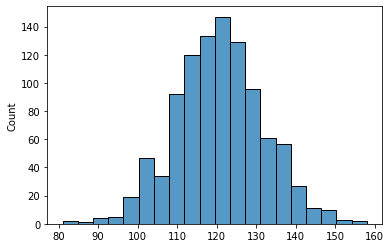

In [51]:
l=[]
for effects_df in filtered_effects_dict.values():
    effects_df=effects_df[effects_df.comm_size=='pair']
    l.append(len(pairs)-len(effects_df))
    
sns.histplot(data=l, bins=20)

In [52]:
# print("Mean\n",k2_summ_df.mean().round(3))
# print("Median\n",k2_summ_df.median().round(3))
# print("STD\n", k2_summ_df.std().round(3))
# print("Coefficient of variation\n",(k2_summ_df.std()/k2_summ_df.mean()).round(3))

k2_sumsum=pd.DataFrame()
# k2_sumsum['original']=(.mean().round(3))
k2_sumsum['mean']=(k2_summ_df.mean().round(3))
k2_sumsum['mean']=(k2_summ_df.mean().round(3))
k2_sumsum['median']=(k2_summ_df.median().round(3))
k2_sumsum['std']=(k2_summ_df.std().round(3))
k2_sumsum['CoV']=((k2_summ_df.std()/k2_summ_df.mean()).round(3))
k2_sumsum

# additive 0.663
# mean 0.464
# OD_W_mean 0.37
# strongest 0.263
# modified_strongest 0.244


,mean,median,std,CoV
additive,0.460,0.460,0.007,0.016
mean,0.318,0.318,0.005,0.017
OD_W_mean,0.237,0.237,0.004,0.019
strongest,0.160,0.159,0.005,0.033
modified_strongest,0.157,0.157,0.005,0.032


additive v.s. mean: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=1.000e+06
mean v.s. OD_W_mean: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=1.000e+06
OD_W_mean v.s. strongest: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=1.000e+06
strongest v.s. modified_strongest: Mann-Whitney-Wilcoxon test two-sided, P_val=2.707e-21 U_stat=6.223e+05
additive v.s. OD_W_mean: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=1.000e+06
mean v.s. strongest: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=1.000e+06
OD_W_mean v.s. modified_strongest: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=1.000e+06
additive v.s. strongest: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=1.000e+06
mean v.s. modified_strongest: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=1.000e+06
additive v.s. modified_strongest: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=1.000e+06


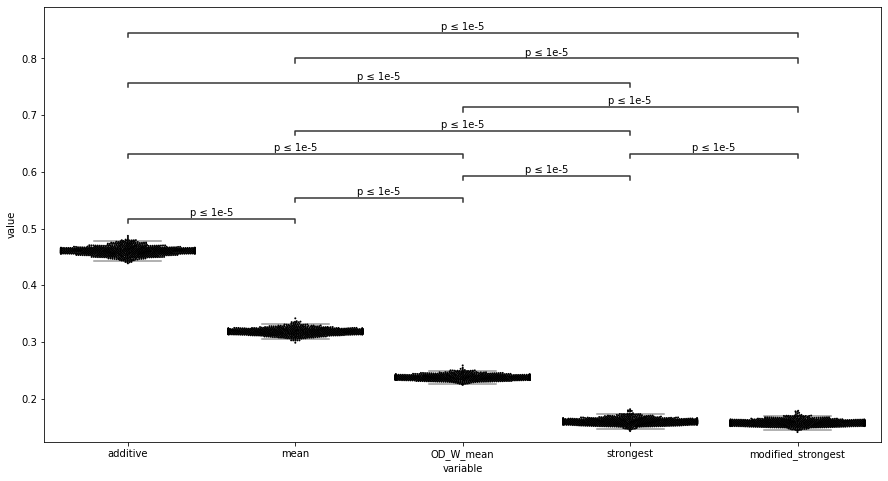

In [53]:
fig, axes = plt.subplots(1,1,figsize=(15,8))

data=k2_summ_df.melt()


ax=sns.boxplot(data=data, x='variable', y='value',color='white', fliersize=0)
ax=sns.swarmplot(data=data, x='variable', y='value',size=2, color='black')

add_stat_annotation(ax, data=data, x="variable", y="value",
                   box_pairs=list(itertools.combinations(list(k2_summ_df),2)),
                   test='Mann-Whitney', text_format='simple', verbose=2, comparisons_correction=None);


# ax.set_xlabel('\nPairs from single species                                     '+
#               'Trios from single species                                     Trios from pairs  '+
#               '\n\n         Dataset and model',fontsize=15)
# ax.set_ylabel('nRMSE',fontsize=20)
# ax.yscale=('log')
# ax.set_xticklabels(['Additive', 'Mean', 'Strongest',
#                     'Additive', 'Mean', 'Strongest',
#                     'Additive', 'Mean', 'Strongest',], fontsize=15)
# # ax.tick_params(labelsize=20)
# # ax.set_ylim(-5,4.5)
# plt.tight_layout()
# fig.savefig('FS7_bts.png')


## Models by focal

In [54]:
k2_summ_focal_df=pd.DataFrame()
counter=0
for effects_df in filtered_effects_dict.values():
    for f in effects_df.focal.unique():
        effects_df2=effects_df[effects_df.focal==f]
        for v in ['additive','mean', 'OD_W_mean', 'strongest','modified_strongest']:
            effects_df3=effects_df2[[v,'combined_effect']].dropna()
            iqr=sp.stats.iqr(effects_df3.combined_effect)

            k2_summ_focal_df.at[counter, f+'_'+v]=(((mean_squared_error(effects_df3[v],
                                                                        effects_df3['combined_effect']))**0.5)/iqr)

    counter+=1    
    

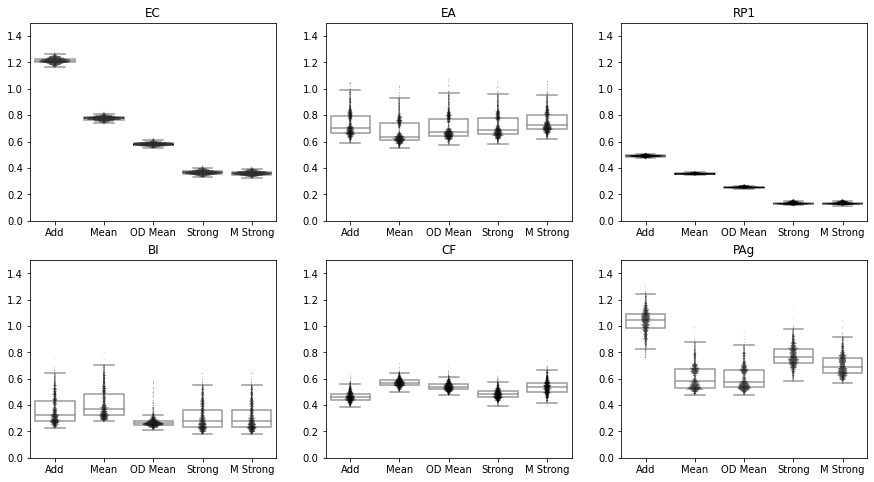

In [55]:
fig, axes = plt.subplots(2,3,figsize=(15,8))

sp_counter=1
for f in effects_df.focal.unique():
    data=k2_summ_focal_df.loc[:, k2_summ_focal_df.columns.str.startswith(f)].melt()
    g=plt.subplot(2, 3, sp_counter)

    g=sns.boxplot(data=data, x='variable', y='value',color='white', fliersize=0)
    g=sns.swarmplot(data=data, x='variable', y='value',size=0.5, color='black')
    g.set_title(f)
    g.set_xticklabels(["Add","Mean","OD Mean","Strong", "M Strong"])
    g.set_xlabel("")
    g.set_ylabel("")
    g.set_ylim(0,1.5)
#     add_stat_annotation(g, data=data, x="variable", y="value",
#                        box_pairs=list(itertools.combinations(list(k2_summ_focal_df.loc[:, k2_summ_focal_df.columns.str.startswith(f)]),2)),
#                        test='Mann-Whitney', text_format='simple', verbose=2, comparisons_correction=None)
    sp_counter+=1

## Models by sign

In [56]:
one_big_data_set=filtered_effects_dict[1]
for i in range (2,repeats): 
    one_big_data_set=one_big_data_set.append(filtered_effects_dict[i])

one_big_data_set=one_big_data_set.reset_index().drop(columns='index')

In [57]:
one_big_data_set['qual_e_1'] = np.where(one_big_data_set['mono_s1_effect'] > 0, '+', '-')
one_big_data_set['qual_e_2'] = np.where(one_big_data_set['mono_s2_effect'] > 0, '+', '-')

def qual_mono (row):
    row['qual_monos']=','.join(sorted(list(row[['qual_e_1','qual_e_2']])))
    return (row)

one_big_data_set=one_big_data_set.apply(qual_mono, axis=1)
one_big_data_set.head(10)

,level_0,sample1,sample2,t1,combined_effect,Count,mono_s1_sample2,mono_s1_effect,mono_s1_Count,mono_s1_max_od,...,mean,additive,OD_W_mean,focal,modified_strongest,comm_size,qual_e_1,qual_e_2,good_to_use,qual_monos
0,0,BI,BI,136.309359,-3.454919,147,BI,-3.454919,147,0.6980,...,-3.454919,-6.909838,-3.454919,EC,-3.454919,single,-,-,y,"-,-"
1,3,BI,CF,48.790566,-4.482309,34,BI,-3.454919,147,0.6980,...,-3.691617,-7.383234,-3.657581,EC,-3.928314,pair,-,-,y,"-,-"
2,5,CF,CF,84.904891,-3.928314,159,CF,-3.928314,159,0.5225,...,-3.928314,-7.856629,-3.928314,EC,-3.928314,single,-,-,y,"-,-"
3,6,BI,EA,170.342406,-3.232036,6,BI,-3.454919,147,0.6980,...,-3.277666,-6.555333,-3.264284,EC,-3.454919,pair,-,-,y,"-,-"
4,8,CF,EA,95.376331,-3.812016,17,CF,-3.928314,159,0.5225,...,-3.514364,-7.028728,-3.424564,EC,-3.928314,pair,-,-,y,"-,-"
5,9,EA,EA,194.305702,-3.100413,104,EA,-3.100413,104,0.8120,...,-3.100413,-6.200827,-3.100413,EC,-3.100413,single,-,-,y,"-,-"
6,10,BI,EC1,177.861822,-3.188839,15,BI,-3.454919,147,0.6980,...,-1.714961,-3.429923,-1.603007,EC,-3.454919,pair,-,+,y,"+,-"
7,12,CF,EC1,104.705738,-3.718692,17,CF,-3.928314,159,0.5225,...,-1.951659,-3.903318,-1.544016,EC,-3.928314,pair,-,+,y,"+,-"
8,13,EA,EC1,164.244041,-3.268493,11,EA,-3.100413,104,0.8120,...,-1.537709,-3.075417,-1.555223,EC,-3.100413,pair,-,+,y,"+,-"
9,14,EC1,EC1,4424.190091,0.024996,216,EC1,0.024996,216,0.7940,...,0.024996,0.049993,0.024996,EC,0.024996,single,+,+,y,"+,+"


In [58]:
qm_dict={'-,-':'Negative-Negative','+,-':'Postive-Negative','+,+':'Postive-Postive'}

k2_summ_qm_df=pd.DataFrame()
counter=0
for effects_df in filtered_effects_dict.values():
    effects_df['qual_e_1'] = np.where(effects_df['mono_s1_effect'] > 0, '+', '-')
    effects_df['qual_e_2'] = np.where(effects_df['mono_s2_effect'] > 0, '+', '-')
    effects_df=effects_df.apply(qual_mono, axis=1)
    
    for qm in effects_df.qual_monos.unique():
        effects_df2=effects_df[effects_df.qual_monos==qm]

        for v in ['additive','mean', 'OD_W_mean', 'strongest','modified_strongest']:
            effects_df3=effects_df2[[v,'combined_effect']].dropna()
            iqr=sp.stats.iqr(effects_df3.combined_effect)

            k2_summ_qm_df.at[counter, qm_dict[qm]+'__'+v]=(((mean_squared_error(effects_df3[v],
                                                                     effects_df3['combined_effect']))**0.5)/iqr)

    counter+=1    
    

Negative-Negative__additive v.s. Negative-Negative__mean: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=1.000e+06
Negative-Negative__mean v.s. Negative-Negative__OD_W_mean: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=9.992e+05
Negative-Negative__OD_W_mean v.s. Negative-Negative__strongest: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=1.000e+06
Negative-Negative__strongest v.s. Negative-Negative__modified_strongest: Mann-Whitney-Wilcoxon test two-sided, P_val=1.000e+00 U_stat=5.000e+05
Negative-Negative__additive v.s. Negative-Negative__OD_W_mean: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=1.000e+06
Negative-Negative__mean v.s. Negative-Negative__strongest: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=1.000e+06
Negative-Negative__OD_W_mean v.s. Negative-Negative__modified_strongest: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=1.000e+06
Negative-Negative__additive v.s. Negative-Negative__st

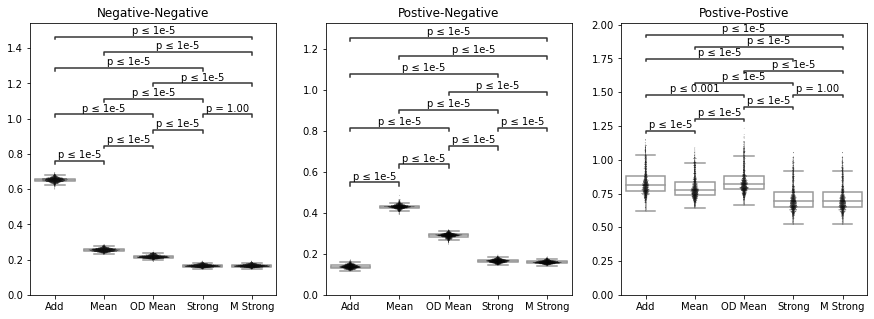

In [59]:
# qm_dict={'-,-':'Negative-Negative','+,-':'Postive-Negative','+,+':'Postive-Postive'}

fig, axes = plt.subplots(1,3,figsize=(15,5))

sp_counter=1
for qm in effects_df.qual_monos.unique():
    data=k2_summ_qm_df.loc[:, k2_summ_qm_df.columns.str.startswith(qm_dict[qm])].melt()
    g=plt.subplot(1, 3, sp_counter)

    g=sns.boxplot(data=data, x='variable', y='value',color='white', fliersize=0)
    g=sns.swarmplot(data=data, x='variable', y='value',size=0.5, color='black')
    g.set_title(qm_dict[qm])
    g.set_xticklabels(["Add","Mean","OD Mean","Strong", "M Strong"])
    g.set_xlabel("")
    g.set_ylabel("")
    g.set_ylim(0,0.8)
    add_stat_annotation(g, data=data, x="variable", y="value",
                       box_pairs=list(itertools.combinations([col for col in k2_summ_qm_df if col.startswith(qm_dict[qm])],2)),
                       test='Mann-Whitney', text_format='simple', verbose=2, comparisons_correction=None)
    sp_counter+=1

In [60]:
k2_summ_df.to_csv('Data/Bootstrap_data/filtered_k2_summ_df.csv')
k2_summ_qm_df.to_csv('Data/Bootstrap_data/filtered_k2_summ_qm_df.csv')
k2_summ_focal_df.to_csv('Data/Bootstrap_data/filtered_k2_summ_focal_df.csv')

# Trios with E coli Focal

## Setup
### Load and normalize data from all chips

In [24]:
#redefine timepoints without t3 for this experiment
timepoints=['t0','t1','t2']


#Import data
path="Data/kChip_data/k3/"
c1=pd.read_csv(path+'chip1.csv')[["t0", "t1","t2","sample1","sample2","sample3"]].dropna()
c2=pd.read_csv(path+'chip2.csv')[["t0", "t1","t2","sample1","sample2","sample3"]].dropna()
c3=pd.read_csv(path+'chip3.csv')[["t0", "t1","t2","sample1","sample2","sample3"]].dropna()

#label each chip seperately and merge to one dataset
c1['chip']='A'
c2['chip']='B'
c3['chip']='C'
k3=c1.append(c2).append(c3)

#normalize to t0
k3[timepoints]=k3[timepoints].sub(k3['t0'], axis=0)
k3[timepoints]=k3[timepoints].clip(lower=1).round(3)
k3=k3.replace(r_phylo_dict)


In [25]:
def pair_effects(row):
    
    try:
        row['pair_12_effect']=pair_effect_dict["['"+row['sample1']+"', '"
                                               +row['sample2']+"']"]
    except KeyError:
        try:
            row['pair_12_effect']=pair_effect_dict["['"+row['sample2']+"', '"
                                               +row['sample1']+"']"]
        except KeyError: row['pair_12_effect']=np.nan
            
    try:
        row['pair_13_effect']=pair_effect_dict["['"+row['sample1']+"', '"
                                               +row['sample3']+"']"]
    except KeyError:
        try:
            row['pair_13_effect']=pair_effect_dict["['"+row['sample3']+"', '"
                                               +row['sample1']+"']"]
        except KeyError: row['pair_13_effect']=np.nan
            
    try:
        row['pair_23_effect']=pair_effect_dict["['"+row['sample3']+"', '"
                                               +row['sample2']+"']"]
    except KeyError:
        try:
            row['pair_23_effect']=pair_effect_dict["['"+row['sample2']+"', '"
                                               +row['sample3']+"']"]
        except KeyError: row['pair_23_effect']=np.nan
            
    row['additive_p']= row["pair_12_effect"]+row["pair_13_effect"]+row["pair_23_effect"]
    row['mean_p']= mean(row[['pair_12_effect', 'pair_13_effect','pair_23_effect']])
    row['strongest_p']=max(row[['pair_12_effect', 'pair_13_effect','pair_23_effect']], key=abs)
                           
    return row

## Orginzing and calculating data

### Calculating effect by trio- orginal dataset

In [26]:
#Agregate mono growth from mono and mono+blank wells
mono_df=pd.DataFrame(columns=list(k3))
for i in list(itertools.product(['Mono1','Blank1'],repeat=3))[:-1]:
    data=k3[(k3['sample1']==i[0])&(k3['sample2']==i[1])&(k3['sample3']==i[2])]
    mono_df=mono_df.append(data)
    
focal_mono_median=mono_df.t1.median()

k3_wB=k3.copy()

k3_wB.sample1=k3_wB.sample1.replace(['Blank1'], np.nan)
k3_wB.sample2=k3_wB.sample2.replace(['Blank1'], np.nan)
k3_wB.sample3=k3_wB.sample3.replace(['Blank1'], np.nan)

k3_wB.sample1 = k3_wB.sample1.fillna(k3_wB.sample2)
k3_wB.sample1 = k3_wB.sample1.fillna(k3_wB.sample3)

k3_wB.sample2 = k3_wB.sample2.fillna(k3_wB.sample1)
k3_wB.sample2 = k3_wB.sample2.fillna(k3_wB.sample3)

k3_wB.sample3 = k3_wB.sample3.fillna(k3_wB.sample1)
k3_wB.sample3 = k3_wB.sample3.fillna(k3_wB.sample2)

k3_wB[['sample1','sample2','sample3']]=k3_wB[['sample1','sample2',
                                                          'sample3']].fillna('Blank1')

k3_wB_bs=k3_wB.sample(len(k3), replace=False)

k3_effect_data=k3_wB_bs.groupby(['sample1','sample2','sample3'], 
                         as_index=False)['t1'].median()

k3_effect_data['combined_effect']=log(k3_effect_data['t1']/focal_mono_median)

k3_effect_data['Count']=k3_wB_bs.groupby(['sample1', 'sample2','sample3'], 
                                  as_index=False)['t1'].count()['t1']

#add data for each bug on its own
mono=(k3_effect_data[(k3_effect_data.sample1==k3_effect_data.sample2)&
                  (k3_effect_data.sample1==k3_effect_data.sample3)][['sample1','combined_effect', 
                                                               'Count']]
       .rename(columns={'combined_effect':'effect'}))
mono['qual_e'] = np.where(mono['effect'] > 0, '+', '-')
mono['max_od'] = mono.sample1.map(max_od_dict)


monos1=mono.add_prefix('mono_s1_')
k3_effect_data=k3_effect_data.merge(monos1, how='left', left_on='sample1',
                              right_on='mono_s1_sample1').drop('mono_s1_sample1',
                                                               axis=1)

monos2=mono.add_prefix('mono_s2_')
k3_effect_data=k3_effect_data.merge(monos2, how='left', left_on='sample2',
                              right_on='mono_s2_sample1').drop('mono_s2_sample1',
                                                               axis=1)

monos3=mono.add_prefix('mono_s3_')
k3_effect_data=k3_effect_data.merge(monos3, how='left', left_on='sample3',
                              right_on='mono_s3_sample1').drop('mono_s3_sample1',
                                                               axis=1)


k3_effect_data['additive_s']=(k3_effect_data["mono_s1_effect"]+
                            k3_effect_data["mono_s2_effect"]+
                            k3_effect_data["mono_s3_effect"])

k3_effect_data['mean_s']=mean(k3_effect_data[["mono_s1_effect","mono_s2_effect","mono_s3_effect"]],axis=1)

k3_effect_data['strongest_s'] = k3_effect_data.apply(lambda x: max(x[["mono_s1_effect","mono_s2_effect",
                                                                    "mono_s3_effect"]],key=abs), axis=1)

k3_effect_data['OD_W_mean']=(((k3_effect_data["mono_s1_effect"]*k3_effect_data["mono_s1_max_od"])+
                              (k3_effect_data["mono_s2_effect"]*k3_effect_data["mono_s2_max_od"])+
                              (k3_effect_data["mono_s3_effect"]*k3_effect_data["mono_s3_max_od"]))/
                              sum(k3_effect_data[["mono_s1_max_od","mono_s2_max_od","mono_s3_max_od"]],axis=1))


original_k3=k3_effect_data[k3_effect_data['Count']>2]


In [27]:
for r in original_k3.index:
    row=original_k3.loc[r]

    if ((row.sample1!=row.sample2)&
        (row.sample1!=row.sample3)&
        (row.sample2!=row.sample3)&
        (row.sample1!='Mono1')&(row.sample2!='Mono1')&(row.sample3!='Mono1')):

        original_k3.at[r,'comm_size']='trio'

    elif(((row.sample1==row.sample2)&(row.sample1!=row.sample3)&
          (row.sample1!='Mono1')&(row.sample3!='Mono1'))|

         ((row.sample1==row.sample3)&(row.sample1!=row.sample2)&
          (row.sample1!='Mono1')&(row.sample2!='Mono1'))|

         ((row.sample2==row.sample3)&(row.sample2!=row.sample1)&
          (row.sample1!='Mono1')&(row.sample3!='Mono1'))|

         ((row.sample1=='Mono1')&(row.sample2!='Mono1')&
          (row.sample3!='Mono1')&(row.sample2!=row.sample3))|
         ((row.sample2=='Mono1')&(row.sample1!='Mono1')&
          (row.sample3!='Mono1')&(row.sample1!=row.sample3))|
         ((row.sample3=='Mono1')&(row.sample2!='Mono1')&
          (row.sample1!='Mono1')&(row.sample2!=row.sample1))):

        original_k3.at[r,'comm_size']='pair'

    else: original_k3.at[r,'comm_size']='single'

#calculate pair effects
pair_data=original_k3[original_k3.comm_size=='pair']

#merge wells with monos with wells without 
pair_data[['sample1','sample2','sample3',]]=pair_data[['sample1','sample2','sample3',]].replace(['Mono1'], np.nan)

pair_data.sample1 = pair_data.sample1.fillna(pair_data.sample2)
pair_data.sample1 = pair_data.sample1.fillna(pair_data.sample3)

pair_data.sample2 = pair_data.sample2.fillna(pair_data.sample1)
pair_data.sample2 = pair_data.sample2.fillna(pair_data.sample3)

pair_data.sample3 = pair_data.sample3.fillna(pair_data.sample1)
pair_data.sample3 = pair_data.sample3.fillna(pair_data.sample2)

#add column for with pair for each row
pair_data['trio'] =((pair_data[['sample1','sample2','sample3']]).values.tolist())
pair_data['pair'] = pair_data.apply(lambda x: sorted(list(set(x['trio']))),axis=1)
pair_data['pair'] = pair_data.apply(lambda x: (str(x['pair'])),axis=1)
pair_data['trio'] = pair_data.apply(lambda x: (str(x['trio'])),axis=1)

#organize data for comparison between diff starting densities
melted=pair_data.melt(id_vars=['pair'], value_vars=['combined_effect'],)
pair_pairs=pd.DataFrame(columns=['pair','ratio1','ratio2','ratio3'],index=range(len(list(melted.pair.unique()))))

#new dataset with 2:1 and 1:2 ratios in each row
for n,ii in enumerate(list(melted.pair.unique())):
    if len(melted[melted.pair==ii])==3:
        pair_pairs.loc[n]['pair']=ii
        pair_pairs.loc[n]['ratio1']=(list((melted[melted.pair==ii]).value))[0]
        pair_pairs.loc[n]['ratio2']=(list((melted[melted.pair==ii]).value))[1]
        pair_pairs.loc[n]['ratio3']=(list((melted[melted.pair==ii]).value))[2]
    elif len(melted[melted.pair==i])==2:
        pair_pairs.loc[n]['pair']=ii
        pair_pairs.loc[n]['ratio1']=(list((melted[melted.pair==ii]).value))[0]
        pair_pairs.loc[n]['ratio2']=(list((melted[melted.pair==ii]).value))[1]

    #16 pairs only have one ratio, but are included here to use in the dictionary downstream 
    elif len(melted[melted.pair==ii])==1:
        pair_pairs.loc[n]['pair']=i
        pair_pairs.loc[n]['ratio1']=(list((melted[melted.pair==ii]).value))[0]
        pair_pairs.loc[n]['ratio2']=(list((melted[melted.pair==ii]).value))[0]

    else: continue

pair_effect_dict=melted.groupby('pair').mean()['value'].to_dict()

#calculate trio predictoins based on pairs
original_k3=original_k3.apply(pair_effects,axis=1)  
original_k3=original_k3.reset_index()

In [28]:
k3_usable=pd.DataFrame(usable_isos_dict['EC'])[0].to_list()+monos

for i in original_k3.index:
    if (original_k3.at[i,'sample1'] in k3_usable and
        original_k3.at[i,'sample2'] in k3_usable and
        original_k3.at[i,'sample3'] in k3_usable):
        original_k3.at[i,'good_to_use']='y'

    else:
        original_k3.at[i,'good_to_use']='n'
        
original_k3=original_k3[original_k3.good_to_use=='y']
original_k3.head(5)

,index,sample1,sample2,sample3,t1,combined_effect,Count,mono_s1_effect,mono_s1_Count,mono_s1_qual_e,...,strongest_s,OD_W_mean,comm_size,pair_12_effect,pair_13_effect,pair_23_effect,additive_p,mean_p,strongest_p,good_to_use
0,0,BI,BI,BI,160.7930,-3.524549,15,-3.524549,15,-,...,-3.524549,-3.524549,single,NaN,NaN,NaN,NaN,NaN,NaN,y
1,1,BI,BI,EA,137.8620,-3.678414,11,-3.524549,15,-,...,-3.524549,-3.402703,pair,NaN,-3.881746,-3.881746,NaN,-3.881746,NaN,y
2,2,BI,BI,EC18,407.1120,-2.595579,21,-3.524549,15,-,...,-3.524549,-3.051997,pair,NaN,-2.499102,-2.499102,NaN,-2.499102,NaN,y
4,4,BI,BI,Gh11,123.1405,-3.791341,8,-3.524549,15,-,...,-3.524549,-3.354156,pair,NaN,-3.808522,-3.808522,NaN,-3.808522,NaN,y
5,5,BI,BI,Gh12,252.2345,-3.074308,12,-3.524549,15,-,...,-3.524549,-3.004183,pair,NaN,-2.763344,-2.763344,NaN,-2.763344,NaN,y


In [29]:
k3_summ_original=pd.DataFrame(columns=['additive_s','mean_s','OD_W_mean','strongest_s',
                                 'additive_p','mean_p','strongest_p'])
counter=0
for v in ['additive_s','mean_s','OD_W_mean','strongest_s',
          'additive_p','mean_p','strongest_p']:
    effects_df=original_k3[original_k3.comm_size=='trio']
    effects_df2=effects_df[[v,'combined_effect']].dropna()
    iqr=sp.stats.iqr(effects_df2.combined_effect)

    k3_summ_original.at[counter, v]=(((mean_squared_error(effects_df2[v],effects_df2['combined_effect']))**0.5)/iqr)
        
counter+=1 

print("Mean")
print(k3_summ_original.mean().round(3))


Mean
additive_s     3.189
mean_s         1.374
OD_W_mean      1.009
strongest_s    0.531
additive_p     5.217
mean_p         0.633
strongest_p    0.434
dtype: float64


### Calculating effect by trio- Bootstrapping

In [30]:
repeats=1001
k3_effects_dict={}

        
#Agregate mono growth from mono and mono+blank wells
mono_df=pd.DataFrame(columns=list(k3))
for i in list(itertools.product(['Mono1','Blank1'],repeat=3))[:-1]:
    data=k3[(k3['sample1']==i[0])&(k3['sample2']==i[1])&(k3['sample3']==i[2])]
    mono_df=mono_df.append(data)
    
focal_mono_median=mono_df.t1.median()

k3_wB=k3.copy()

k3_wB.sample1=k3_wB.sample1.replace(['Blank1'], np.nan)
k3_wB.sample2=k3_wB.sample2.replace(['Blank1'], np.nan)
k3_wB.sample3=k3_wB.sample3.replace(['Blank1'], np.nan)

k3_wB.sample1 = k3_wB.sample1.fillna(k3_wB.sample2)
k3_wB.sample1 = k3_wB.sample1.fillna(k3_wB.sample3)

k3_wB.sample2 = k3_wB.sample2.fillna(k3_wB.sample1)
k3_wB.sample2 = k3_wB.sample2.fillna(k3_wB.sample3)

k3_wB.sample3 = k3_wB.sample3.fillna(k3_wB.sample1)
k3_wB.sample3 = k3_wB.sample3.fillna(k3_wB.sample2)

k3_wB[['sample1','sample2','sample3']]=k3_wB[['sample1','sample2',
                                                          'sample3']].fillna('Blank1')

for i in range(1,repeats):

    k3_wB_bs=k3_wB.sample(len(k3), replace=True, random_state=i)

    k3_effect_data=k3_wB_bs.groupby(['sample1','sample2','sample3'], 
                             as_index=False)['t1'].median()

    k3_effect_data['combined_effect']=log(k3_effect_data['t1']/focal_mono_median)

    k3_effect_data['Count']=k3_wB_bs.groupby(['sample1', 'sample2','sample3'], 
                                      as_index=False)['t1'].count()['t1']

    #add data for each bug on its own
    mono=(k3_effect_data[(k3_effect_data.sample1==k3_effect_data.sample2)&
                      (k3_effect_data.sample1==k3_effect_data.sample3)][['sample1','combined_effect', 
                                                                   'Count']]
           .rename(columns={'combined_effect':'effect'}))
    mono['qual_e'] = np.where(mono['effect'] > 0, '+', '-')
    mono['max_od'] = mono.sample1.map(max_od_dict)


    monos1=mono.add_prefix('mono_s1_')
    k3_effect_data=k3_effect_data.merge(monos1, how='left', left_on='sample1',
                                  right_on='mono_s1_sample1').drop('mono_s1_sample1',
                                                                   axis=1)

    monos2=mono.add_prefix('mono_s2_')
    k3_effect_data=k3_effect_data.merge(monos2, how='left', left_on='sample2',
                                  right_on='mono_s2_sample1').drop('mono_s2_sample1',
                                                                   axis=1)

    monos3=mono.add_prefix('mono_s3_')
    k3_effect_data=k3_effect_data.merge(monos3, how='left', left_on='sample3',
                                  right_on='mono_s3_sample1').drop('mono_s3_sample1',
                                                                   axis=1)


    k3_effect_data['additive_s']=(k3_effect_data["mono_s1_effect"]+
                                k3_effect_data["mono_s2_effect"]+
                                k3_effect_data["mono_s3_effect"])

    k3_effect_data['mean_s']=mean(k3_effect_data[["mono_s1_effect","mono_s2_effect","mono_s3_effect"]],axis=1)

    k3_effect_data['strongest_s'] = k3_effect_data.apply(lambda x: max(x[["mono_s1_effect","mono_s2_effect",
                                                                        "mono_s3_effect"]],key=abs), axis=1)
    
    k3_effect_data['OD_W_mean']=(((k3_effect_data["mono_s1_effect"]*k3_effect_data["mono_s1_max_od"])+
                                  (k3_effect_data["mono_s2_effect"]*k3_effect_data["mono_s2_max_od"])+
                                  (k3_effect_data["mono_s3_effect"]*k3_effect_data["mono_s3_max_od"]))/
                                  sum(k3_effect_data[["mono_s1_max_od","mono_s2_max_od","mono_s3_max_od"]],axis=1))


    k3_effects_dict[i]=k3_effect_data[k3_effect_data['Count']>2]


In [61]:
k3_usable=pd.DataFrame(usable_isos_dict['EC'])[0].to_list()+monos
filtred_k3_effects_dict={}

for i in range(1,repeats):
    #call each bootstrap individually
    temp_data=k3_effects_dict[i]
    
for i in temp_data.index:
    if (temp_data.at[i,'sample1'] in k3_usable and
        temp_data.at[i,'sample2'] in k3_usable and
        temp_data.at[i,'sample3'] in k3_usable):
        temp_data.at[i,'good_to_use']='y'

    else:
        temp_data.at[i,'good_to_use']='n'
        
filtred_k3_effects_dict=temp_data[temp_data.good_to_use=='y']


In [62]:
for i in range(1,repeats):
    #call each bootstrap individually
    temp_data=k3_effects_dict[i]
    
    #add comm_size column
    for r in temp_data.index:
        row=temp_data.loc[r]

        if ((row.sample1!=row.sample2)&
            (row.sample1!=row.sample3)&
            (row.sample2!=row.sample3)&
            (row.sample1!='Mono1')&(row.sample2!='Mono1')&(row.sample3!='Mono1')):

            temp_data.at[r,'comm_size']='trio'

        elif(((row.sample1==row.sample2)&(row.sample1!=row.sample3)&
              (row.sample1!='Mono1')&(row.sample3!='Mono1'))|

             ((row.sample1==row.sample3)&(row.sample1!=row.sample2)&
              (row.sample1!='Mono1')&(row.sample2!='Mono1'))|

             ((row.sample2==row.sample3)&(row.sample2!=row.sample1)&
              (row.sample1!='Mono1')&(row.sample3!='Mono1'))|

             ((row.sample1=='Mono1')&(row.sample2!='Mono1')&
              (row.sample3!='Mono1')&(row.sample2!=row.sample3))|
             ((row.sample2=='Mono1')&(row.sample1!='Mono1')&
              (row.sample3!='Mono1')&(row.sample1!=row.sample3))|
             ((row.sample3=='Mono1')&(row.sample2!='Mono1')&
              (row.sample1!='Mono1')&(row.sample2!=row.sample1))):
                
            temp_data.at[r,'comm_size']='pair'

        else: temp_data.at[r,'comm_size']='single'

    #calculate pair effects
    pair_data=temp_data[temp_data.comm_size=='pair']
    
    #merge wells with monos with wells without 
    pair_data[['sample1','sample2','sample3',]]=pair_data[['sample1','sample2','sample3',]].replace(['Mono1'], np.nan)

    pair_data.sample1 = pair_data.sample1.fillna(pair_data.sample2)
    pair_data.sample1 = pair_data.sample1.fillna(pair_data.sample3)

    pair_data.sample2 = pair_data.sample2.fillna(pair_data.sample1)
    pair_data.sample2 = pair_data.sample2.fillna(pair_data.sample3)

    pair_data.sample3 = pair_data.sample3.fillna(pair_data.sample1)
    pair_data.sample3 = pair_data.sample3.fillna(pair_data.sample2)

    #add column for with pair for each row
    pair_data['trio'] =((pair_data[['sample1','sample2','sample3']]).values.tolist())
    pair_data['pair'] = pair_data.apply(lambda x: sorted(list(set(x['trio']))),axis=1)
    pair_data['pair'] = pair_data.apply(lambda x: (str(x['pair'])),axis=1)
    pair_data['trio'] = pair_data.apply(lambda x: (str(x['trio'])),axis=1)

    #organize data for comparison between diff starting densities
    melted=pair_data.melt(id_vars=['pair'], value_vars=['combined_effect'],)
    pair_pairs=pd.DataFrame(columns=['pair','ratio1','ratio2','ratio3'],index=range(len(list(melted.pair.unique()))))

    #new dataset with 2:1 and 1:2 ratios in each row
    for n,ii in enumerate(list(melted.pair.unique())):
        if len(melted[melted.pair==ii])==3:
            pair_pairs.loc[n]['pair']=ii
            pair_pairs.loc[n]['ratio1']=(list((melted[melted.pair==ii]).value))[0]
            pair_pairs.loc[n]['ratio2']=(list((melted[melted.pair==ii]).value))[1]
            pair_pairs.loc[n]['ratio3']=(list((melted[melted.pair==ii]).value))[2]
        elif len(melted[melted.pair==i])==2:
            pair_pairs.loc[n]['pair']=ii
            pair_pairs.loc[n]['ratio1']=(list((melted[melted.pair==ii]).value))[0]
            pair_pairs.loc[n]['ratio2']=(list((melted[melted.pair==ii]).value))[1]
    
        #16 pairs only have one ratio, but are included here to use in the dictionary downstream 
        elif len(melted[melted.pair==ii])==1:
            pair_pairs.loc[n]['pair']=i
            pair_pairs.loc[n]['ratio1']=(list((melted[melted.pair==ii]).value))[0]
            pair_pairs.loc[n]['ratio2']=(list((melted[melted.pair==ii]).value))[0]

        else: continue

    pair_effect_dict=melted.groupby('pair').mean()['value'].to_dict()
    
    #calculate trio predictoins based on pairs
    k3_effects_dict[i]=temp_data.apply(pair_effects,axis=1)  


In [63]:
k3_summ_df=pd.DataFrame(columns=['additive_s','mean_s','OD_W_mean','strongest_s',
                                 'additive_p','mean_p','strongest_p'])
counter=0
for effects_df in k3_effects_dict.values():
    for v in ['additive_s','mean_s','OD_W_mean','strongest_s',
              'additive_p','mean_p','strongest_p']:
        effects_df=effects_df[effects_df.comm_size=='trio']
        effects_df2=effects_df[[v,'combined_effect']].dropna()
        iqr=sp.stats.iqr(effects_df2.combined_effect)
        
        k3_summ_df.at[counter, v]=(((mean_squared_error(effects_df2[v],effects_df2['combined_effect']))**0.5)/iqr)
        
    counter+=1    

In [64]:
k3_sumsum=pd.DataFrame()
k3_sumsum['original']=(k3_summ_original.mean().round(3))
k3_sumsum['mean']=(k3_summ_df.mean().round(3))
k3_sumsum['mean']=(k3_summ_df.mean().round(3))
k3_sumsum['median']=(k3_summ_df.median().round(3))
k3_sumsum['std']=(k3_summ_df.std().round(3))
k3_sumsum['CoV']=((k3_summ_df.std()/k3_summ_df.mean()).round(3))
k3_sumsum


,original,mean,median,std,CoV
additive_s,3.189,2.671,2.655,0.158,0.059
mean_s,1.374,1.229,1.229,0.043,0.035
OD_W_mean,1.009,0.986,0.985,0.029,0.029
strongest_s,0.531,0.657,0.630,0.074,0.113
additive_p,5.217,4.328,4.329,0.071,0.016
mean_p,0.633,0.673,0.672,0.016,0.023
strongest_p,0.434,0.569,0.566,0.025,0.044


<AxesSubplot:>

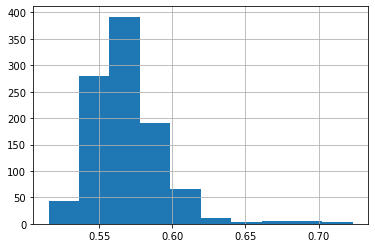

In [65]:
k3_summ_df.strongest_p.hist()

additive_s v.s. mean_s: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=1.000e+06
mean_s v.s. OD_W_mean: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=1.000e+06
OD_W_mean v.s. strongest_s: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=9.997e+05
additive_s v.s. OD_W_mean: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=1.000e+06
mean_s v.s. strongest_s: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=1.000e+06
additive_s v.s. strongest_s: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=1.000e+06
additive_p v.s. mean_p: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=1.000e+06
mean_p v.s. strongest_p: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=9.900e+05
additive_p v.s. strongest_p: Mann-Whitney-Wilcoxon test two-sided, P_val=0.000e+00 U_stat=1.000e+06


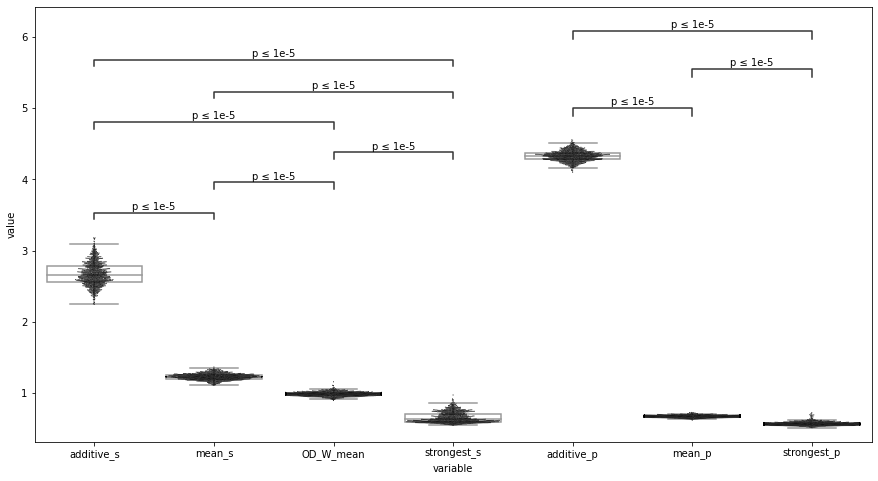

In [66]:
fig, axes = plt.subplots(1,1,figsize=(15,8))

data=k3_summ_df.melt()


ax=sns.boxplot(data=data, x='variable', y='value',color='white', fliersize=0)
ax=sns.swarmplot(data=data, x='variable', y='value',size=1, color='black')

add_stat_annotation(ax, data=data, x="variable", y="value",
                   box_pairs=list(itertools.combinations(list(k3_summ_df)[:4],2)),
                   test='Mann-Whitney', text_format='simple', verbose=2, comparisons_correction=None)

add_stat_annotation(ax, data=data, x="variable", y="value",
                   box_pairs=list(itertools.combinations(list(k3_summ_df)[4:],2)),
                   test='Mann-Whitney', text_format='simple', verbose=2, comparisons_correction=None);


# ax.set_xlabel('\nPairs from single species                                     '+
#               'Trios from single species                                     Trios from pairs  '+
#               '\n\n         Dataset and model',fontsize=15)
# ax.set_ylabel('nRMSE',fontsize=20)
# ax.yscale=('log')
# ax.set_xticklabels(['Additive', 'Mean', 'Strongest',
#                     'Additive', 'Mean', 'Strongest',
#                     'Additive', 'Mean', 'Strongest',], fontsize=15)
# # ax.tick_params(labelsize=20)
# # ax.set_ylim(-5,4.5)
# plt.tight_layout()
# fig.savefig('FS7_bts.png')


In [67]:
k3_summ_df.to_csv('Data/Bootstrap_data/filtered_k3_summ_df.csv')